In [1]:
import argparse
import gym
from gym import wrappers
import os.path as osp
import random
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers

import dqn
from dqn_utils import *
from atari_wrappers import *
import pickle
from run_dqn_atari import *

In [2]:
benchmark = gym.benchmark_spec('Atari40M')
task = benchmark.tasks[3]
seed = 0
env = get_env(task, seed)
# session = get_session()
task.max_timesteps
num_actions = env.action_space.n

[2017-12-16 17:35:18,951] Making new env: PongNoFrameskip-v4
[2017-12-16 17:35:19,346] Clearing 4 monitor files from previous run (because force=True was provided)


In [4]:
def atari_model(img_in, num_actions, scope, reuse=False):
    # as described in https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
    with tf.variable_scope(scope, reuse=reuse):
        out = img_in
        with tf.variable_scope("convnet"):
            # original architecture
            out = layers.convolution2d(out, num_outputs=32, kernel_size=8, stride=4, activation_fn=tf.nn.relu)
            out = layers.convolution2d(out, num_outputs=64, kernel_size=4, stride=2, activation_fn=tf.nn.relu)
            out = layers.convolution2d(out, num_outputs=64, kernel_size=3, stride=1, activation_fn=tf.nn.relu)
        out = layers.flatten(out)
        with tf.variable_scope("action_value"):
            out = layers.fully_connected(out, num_outputs=512,         activation_fn=tf.nn.relu)
            out = layers.fully_connected(out, num_outputs=num_actions, activation_fn=None)

        return out

In [5]:
sess = get_session()
saver = tf.train.import_meta_graph('pong.meta')
saver.restore(sess,tf.train.latest_checkpoint('./'))
graph = tf.get_default_graph()

AVAILABLE GPUS:  []


In [6]:
target_q_func_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_q_func')

In [7]:
print(target_q_func_vars)

[<tensorflow.python.ops.variables.Variable object at 0x1280b05f8>, <tensorflow.python.ops.variables.Variable object at 0x1280b0a20>, <tensorflow.python.ops.variables.Variable object at 0x1280b0f60>, <tensorflow.python.ops.variables.Variable object at 0x1280b0cf8>, <tensorflow.python.ops.variables.Variable object at 0x1280b0668>, <tensorflow.python.ops.variables.Variable object at 0x1280b0ef0>, <tensorflow.python.ops.variables.Variable object at 0x1280b0cc0>, <tensorflow.python.ops.variables.Variable object at 0x1280b0470>, <tensorflow.python.ops.variables.Variable object at 0x1280b0780>, <tensorflow.python.ops.variables.Variable object at 0x1280b0ac8>]


In [8]:
target_q_func_Conv = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_q_func')

In [9]:
for i in target_q_func_vars:
    print(i.name)
# target_q_func_vars[0].assign()

target_q_func/convnet/Conv/weights:0
target_q_func/convnet/Conv/biases:0
target_q_func/convnet/Conv_1/weights:0
target_q_func/convnet/Conv_1/biases:0
target_q_func/convnet/Conv_2/weights:0
target_q_func/convnet/Conv_2/biases:0
target_q_func/action_value/fully_connected/weights:0
target_q_func/action_value/fully_connected/biases:0
target_q_func/action_value/fully_connected_1/weights:0
target_q_func/action_value/fully_connected_1/biases:0


In [10]:
all_vars = tf.global_variables()
for i in all_vars:
    print(i.name)

q_func/convnet/Conv/weights:0
q_func/convnet/Conv/biases:0
q_func/convnet/Conv_1/weights:0
q_func/convnet/Conv_1/biases:0
q_func/convnet/Conv_2/weights:0
q_func/convnet/Conv_2/biases:0
q_func/action_value/fully_connected/weights:0
q_func/action_value/fully_connected/biases:0
q_func/action_value/fully_connected_1/weights:0
q_func/action_value/fully_connected_1/biases:0
target_q_func/convnet/Conv/weights:0
target_q_func/convnet/Conv/biases:0
target_q_func/convnet/Conv_1/weights:0
target_q_func/convnet/Conv_1/biases:0
target_q_func/convnet/Conv_2/weights:0
target_q_func/convnet/Conv_2/biases:0
target_q_func/action_value/fully_connected/weights:0
target_q_func/action_value/fully_connected/biases:0
target_q_func/action_value/fully_connected_1/weights:0
target_q_func/action_value/fully_connected_1/biases:0
beta1_power:0
beta2_power:0
q_func/convnet/Conv/weights/Adam:0
q_func/convnet/Conv/weights/Adam_1:0
q_func/convnet/Conv/biases/Adam:0
q_func/convnet/Conv/biases/Adam_1:0
q_func/convnet/Con

In [11]:
first_weight = np.array(sess.run(target_q_func_vars[0]))
first_bias = np.array(sess.run(target_q_func_vars[1]))
                

In [12]:
last_obs = env.reset()
import matplotlib.pyplot as plt
%matplotlib inline
img = np.array(last_obs)
print(img.shape)

[2017-12-16 17:35:27,213] Starting new video recorder writing to /Users/Gin/Downloads/Pong/gym/openaigym.video.0.41816.video000000.mp4


(84, 84, 1)


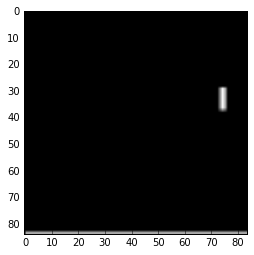

In [13]:
plt.imshow(img.squeeze(), cmap = 'gray')




In [14]:
replay_buffer = ReplayBuffer(1000000, 4)
last_obs = env.reset()
idx = replay_buffer.store_frame(last_obs)

In [15]:
act, reward, done = env.action_space.sample(), 0, False
last_obs, reward, done, info = env.step(act)
replay_buffer.store_effect(idx, act, reward, done)


In [16]:
input_shape = (84, 84, 4)
obs_t_ph              = tf.placeholder(tf.uint8, [None] + list(input_shape))
    # placeholder for current action
act_t_ph              = tf.placeholder(tf.int32,   [None])
    # placeholder for current reward
rew_t_ph              = tf.placeholder(tf.float32, [None])
    # placeholder for next observation (or state)
obs_tp1_ph            = tf.placeholder(tf.uint8, [None] + list(input_shape))
    # placeholder for end of episode mask
    # this value is 1 if the next state corresponds to the end of an episode,
    # in which case there is no Q-value at the next state; at the end of an
    # episode, only the current state reward contributes to the target, not the
    # next state Q-value (i.e. target is just rew_t_ph, not rew_t_ph + gamma * q_tp1)
done_mask_ph          = tf.placeholder(tf.float32, [None])

    # casting to float on GPU ensures lower data transfer times.
obs_t_float   = tf.cast(obs_t_ph,   tf.float32) / 255.0
obs_tp1_float = tf.cast(obs_tp1_ph, tf.float32) / 255.0
num_actions = 6
transfer_model = atari_model(obs_t_float, num_actions, scope = 'tq_func', reuse = False)

In [21]:
tq_func_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = 'tq_func')
update_target_fn = []
for var, var_target in zip(sorted(target_q_func_vars,        key=lambda v: v.name),
                           sorted(tq_func_vars, key=lambda v: v.name)):
#     if 'Conv' in var.name:
    update_target_fn.append(var_target.assign(var))
update_target_fn = tf.group(*update_target_fn)
sess.run(update_target_fn)

In [22]:
for t in range(100):
    idx = replay_buffer.store_frame(last_obs)
    input_batch = replay_buffer.encode_recent_observation()
    q_vals = sess.run(transfer_model, {obs_t_ph: input_batch[None, :]})
    act = np.argmax(q_vals)
    last_obs, reward, done, info = env.step(act)
    replay_buffer.store_effect(idx, act, reward, done)
    if done == True:
        last_obs = env.reset()
        done = False

In [23]:
input_batch = replay_buffer.encode_recent_observation()


(84, 84, 4)


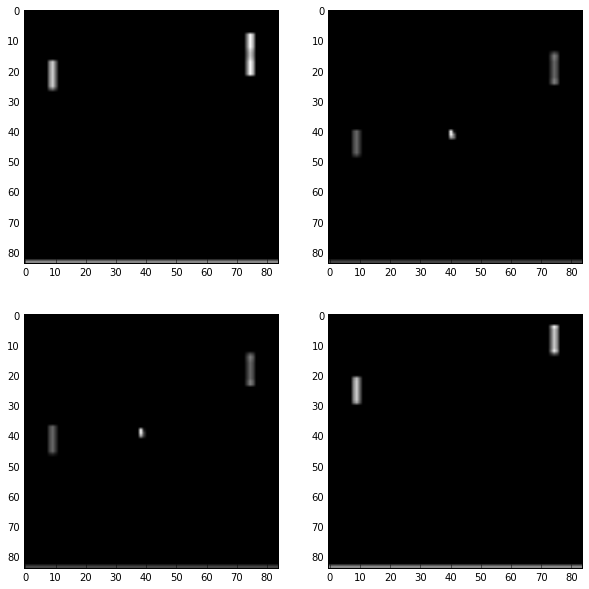

In [24]:
input_batch = replay_buffer.encode_recent_observation()
plot = np.array(input_batch)
print(plot.shape)
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (10, 10))
for i in range(4):
    ax = fig.add_subplot('22%s'%i)
    ax.imshow(plot[:, :, i], cmap = 'gray')#, cmap = 'gray'

In [25]:
out = layers.convolution2d(obs_t_float, num_outputs=32, kernel_size=8, stride=4, activation_fn=tf.nn.relu, scope = 'test')
out1 = layers.convolution2d(out, num_outputs=64, kernel_size=4, stride=2, activation_fn=tf.nn.relu, scope = 'test1')
out2 = layers.convolution2d(out1, num_outputs=64, kernel_size=3, stride=1, activation_fn=tf.nn.relu, scope = 'test2')
test_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = 'test')
test1_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = 'test1')
test2_var = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope = 'test2')

In [26]:
for i in target_q_func_vars:
    print(i.name)

target_q_func/convnet/Conv/weights:0
target_q_func/convnet/Conv/biases:0
target_q_func/convnet/Conv_1/weights:0
target_q_func/convnet/Conv_1/biases:0
target_q_func/convnet/Conv_2/weights:0
target_q_func/convnet/Conv_2/biases:0
target_q_func/action_value/fully_connected/weights:0
target_q_func/action_value/fully_connected/biases:0
target_q_func/action_value/fully_connected_1/weights:0
target_q_func/action_value/fully_connected_1/biases:0


In [27]:
update_fn = []

update_fn.append(test_var[0].assign(target_q_func_vars[0]))
update_fn.append(test_var[1].assign(target_q_func_vars[1]))
update_fn = tf.group(*update_fn)
sess.run(update_fn)

update_fn = []
update_fn.append(test1_var[0].assign(target_q_func_vars[2]))
update_fn.append(test1_var[1].assign(target_q_func_vars[3]))
update_fn = tf.group(*update_fn)
sess.run(update_fn)

update_fn = []
update_fn.append(test2_var[0].assign(target_q_func_vars[4]))
update_fn.append(test2_var[1].assign(target_q_func_vars[5]))
update_fn = tf.group(*update_fn)
sess.run(update_fn)

In [28]:
first_output = sess.run(out, {obs_t_ph: input_batch[None, :]})
second_output = sess.run(out1, {obs_t_ph: input_batch[None, :]})
third_output = sess.run(out2, {obs_t_ph: input_batch[None, :]})

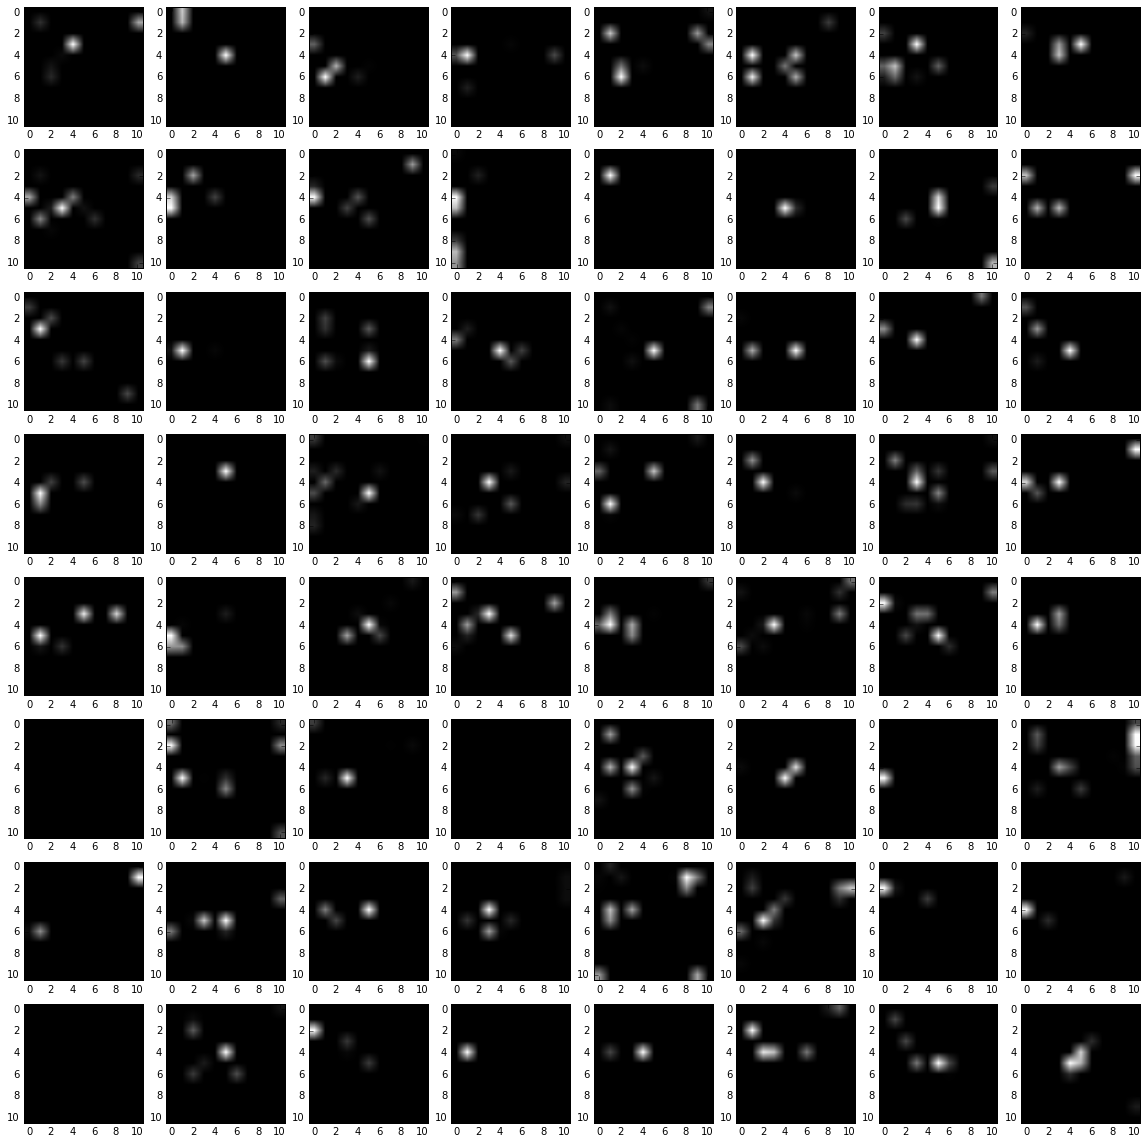

In [29]:
third_output = third_output.squeeze()
fig = plt.figure(figsize = (20, 20))
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1)
    ax.imshow(third_output[:, :,i], cmap = 'gray')#, cmap = 'gray'

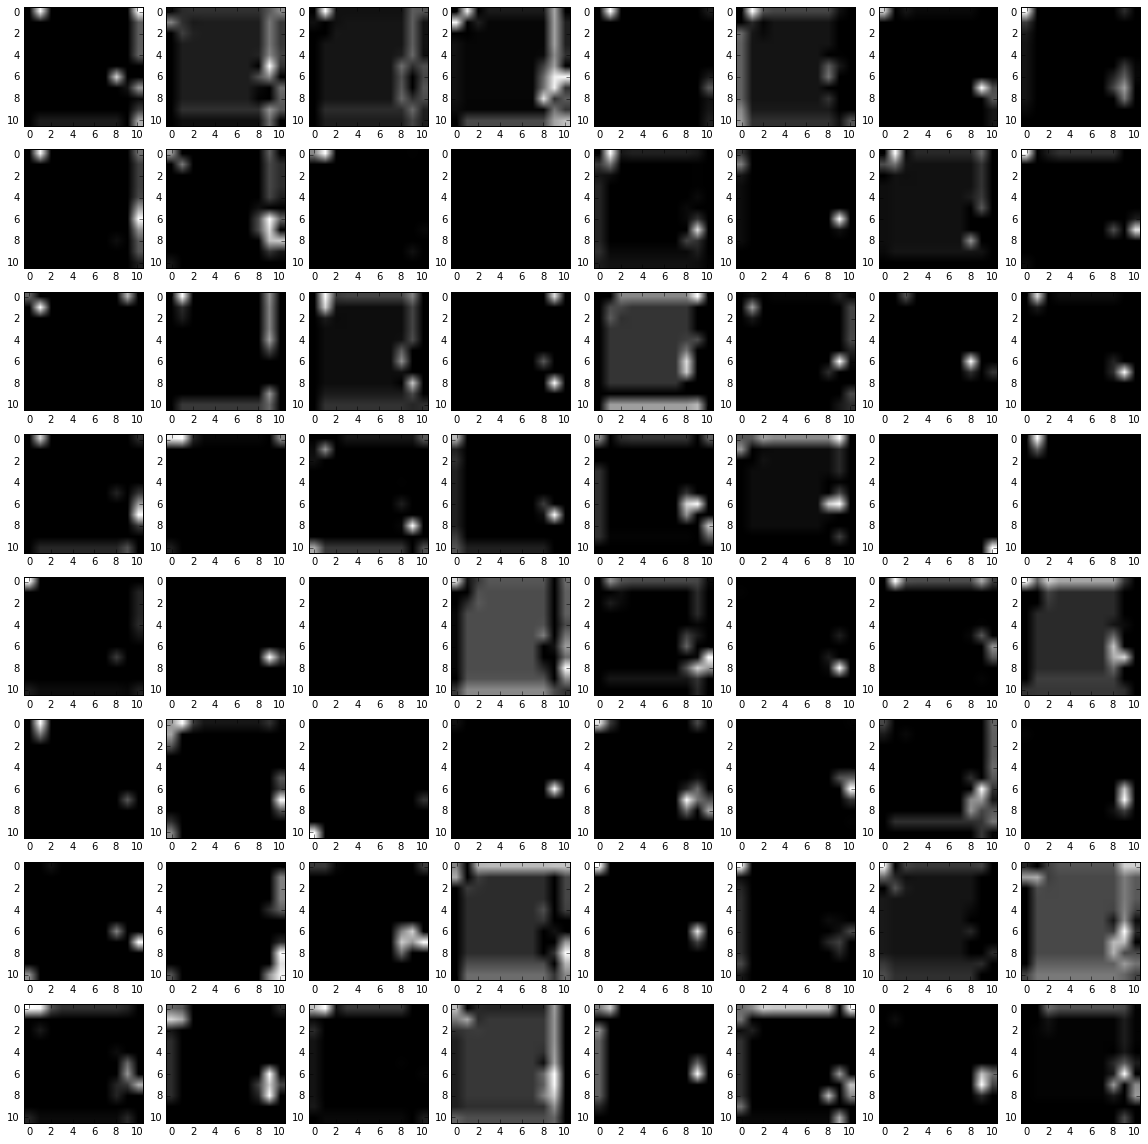

In [53]:
second_output = second_output.squeeze()
fig = plt.figure(figsize = (20, 20))
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1)
    ax.imshow(second_output[:, :,i], cmap = 'gray')#, cmap = 'gray'



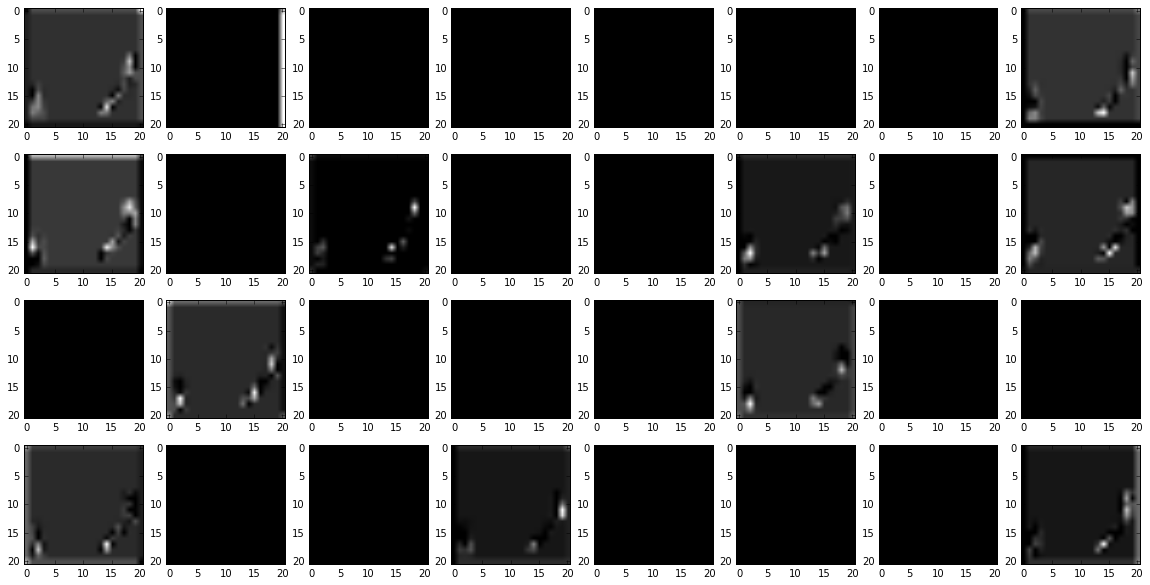

In [39]:
first_output = sess.run(out, {obs_t_ph: input_batch[None, :]})
fig = plt.figure(figsize = (20, 10))
first_output = first_output.squeeze()
for i in range(32):
    ax = fig.add_subplot(4, 8, i + 1)
    ax.imshow(first_output[:, :,i], cmap = 'gray')#, cmap = 'gray'


In [43]:
for t in range(100):
    idx = replay_buffer.store_frame(last_obs)
    input_batch = replay_buffer.encode_recent_observation()
    q_vals = sess.run(transfer_model, {obs_t_ph: input_batch[None, :]})
    act = np.argmax(q_vals)
    last_obs, reward, done, info = env.step(act)
    replay_buffer.store_effect(idx, act, reward, done)
    if done == True:
        last_obs = env.reset()
        done = False

(84, 84, 4)


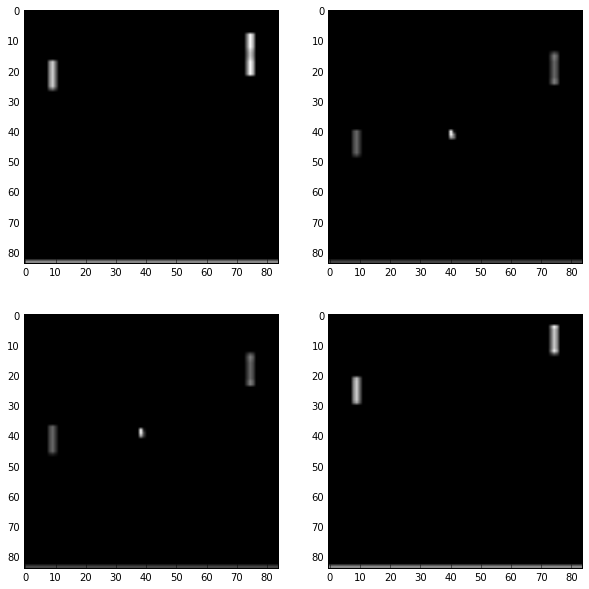

In [30]:
input_batch = replay_buffer.encode_recent_observation()
plot = np.array(input_batch)
print(plot.shape)
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (10, 10))
for i in range(4):
    ax = fig.add_subplot('22%s'%i)
    ax.imshow(plot[:, :, i], cmap = 'gray')#, cmap = 'gray'

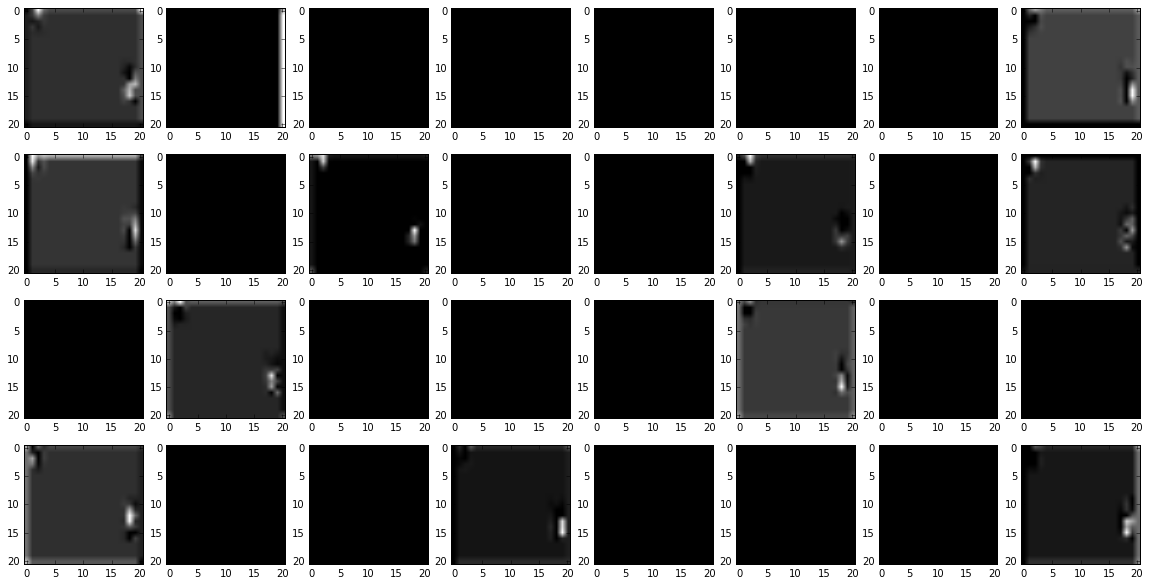

In [45]:
first_output = sess.run(out, {obs_t_ph: input_batch[None, :]})
fig = plt.figure(figsize = (20, 10))
first_output = first_output.squeeze()
for i in range(32):
    ax = fig.add_subplot(4, 8, i + 1)
    ax.imshow(first_output[:, :,i], cmap = 'gray')#, cmap = 'gray'



(8, 8, 4, 32)


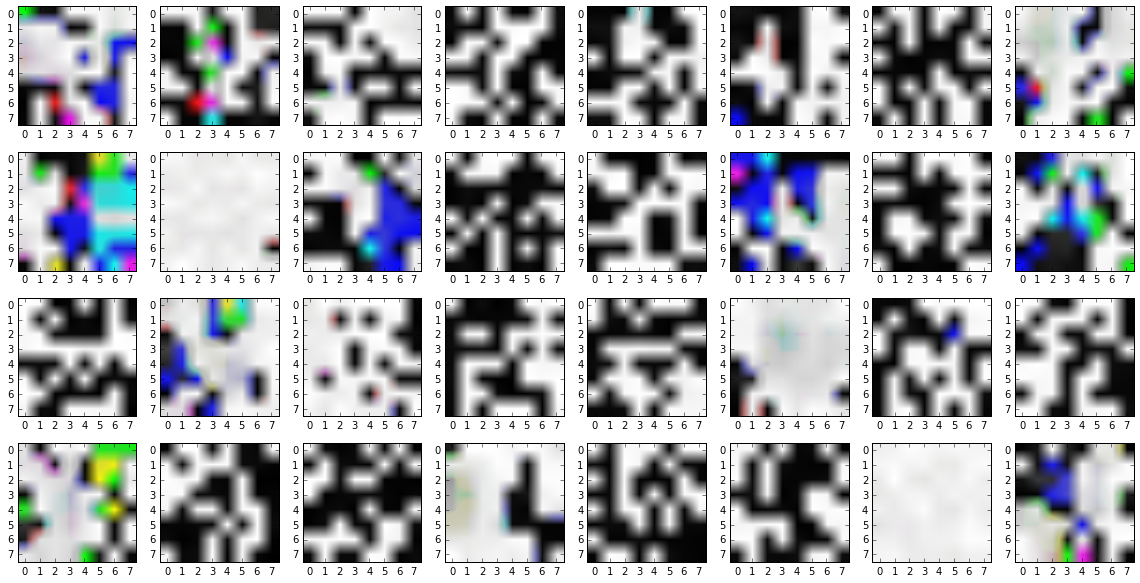

In [38]:
print(first_weight.shape)
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize = (20, 10))
for i in range(32):
    ax = fig.add_subplot(4, 8, i + 1)
    ax.imshow(first_weight[:, :, :, i], cmap = 'gray')#, cmap = 'gray'
    

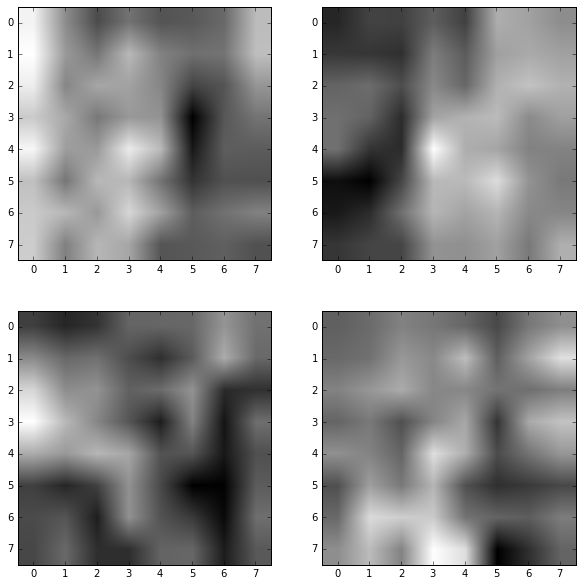

In [41]:
fig = plt.figure(figsize = (10, 10))
for i in range(4):
    ax = fig.add_subplot('22%s'%i)
    ax.imshow(first_weight[:, :, i, 0], cmap = 'gray')#, cmap = 'gray'
    

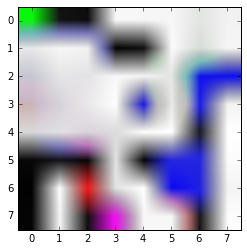

In [42]:
plt.imshow(first_weight[:, :, :, 0], cmap = 'gray')

In [16]:
input_shape = (84, 84, 4)
obs_t_ph              = tf.placeholder(tf.uint8, [None] + list(input_shape))
    # placeholder for current action
act_t_ph              = tf.placeholder(tf.int32,   [None])
    # placeholder for current reward
rew_t_ph              = tf.placeholder(tf.float32, [None])
    # placeholder for next observation (or state)
obs_tp1_ph            = tf.placeholder(tf.uint8, [None] + list(input_shape))
    # placeholder for end of episode mask
    # this value is 1 if the next state corresponds to the end of an episode,
    # in which case there is no Q-value at the next state; at the end of an
    # episode, only the current state reward contributes to the target, not the
    # next state Q-value (i.e. target is just rew_t_ph, not rew_t_ph + gamma * q_tp1)
done_mask_ph          = tf.placeholder(tf.float32, [None])

    # casting to float on GPU ensures lower data transfer times.
obs_t_float   = tf.cast(obs_t_ph,   tf.float32) / 255.0
obs_tp1_float = tf.cast(obs_tp1_ph, tf.float32) / 255.0
num_actions = 6
transfer_model = atari_model(obs_t_float, num_actions, scope = 'tq_func', reuse = False)

In [14]:
print(sess.run(target_q_func_vars[1]))

[-0.14165288 -0.00109254  0.00294678 -0.00587255  0.00082439  0.00065813
 -0.0022113  -0.05366213 -0.03159284  0.1089839  -0.06973385 -0.00668057
 -0.00226963 -0.11261411 -0.00407605 -0.10044876 -0.00451532 -0.10151751
  0.05437373 -0.00821048  0.001611   -0.09339698 -0.01167785 -0.0065322
 -0.05969576 -0.0014765   0.         -0.06066765 -0.00931518 -0.00525611
  0.1051318  -0.06878059]


In [15]:
sess.run(update_target_fn)
print(sess.run(tq_func_vars[1]))

[-0.14165288 -0.00109254  0.00294678 -0.00587255  0.00082439  0.00065813
 -0.0022113  -0.05366213 -0.03159284  0.1089839  -0.06973385 -0.00668057
 -0.00226963 -0.11261411 -0.00407605 -0.10044876 -0.00451532 -0.10151751
  0.05437373 -0.00821048  0.001611   -0.09339698 -0.01167785 -0.0065322
 -0.05969576 -0.0014765   0.         -0.06066765 -0.00931518 -0.00525611
  0.1051318  -0.06878059]
